In [1]:
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics

from rocket import Rocket

import random

In [2]:

#x range: +- 200
#z range: 500, 2000
#vx range: +- 10
#vz range: -30, 10

#m range: 8000, 12000


start_range = ([-200, 200], [500, 2000], [-10,10], [-30, 10], [8000, 12000])


In [3]:
r = Rocket(*[random.uniform(*s) for s in start_range])

In [4]:
#r = Rocket(*[-30., 1000., 10., 20., 10000.])

In [5]:
r

In [6]:
r.s_0

(162.43168863473562,
 1464.0486917167525,
 -3.209917536998381,
 5.796438484073249,
 10175.062668406283)

In [7]:
def og_dynamics(prob, obj, section):
    
    #extract states and controls
    s = tuple([prob.states(i, section) for i in range(5)])
    u = tuple([prob.controls(i, section) for i in range(2)])
    
    
    dx = Dynamics(prob, section)
    
    #get dynamics from the rocket
    ds = obj.dynamics(s, u)
    
    for i in range(5):
        dx[i] = ds[i]
        
    return dx()


def og_equality(prob, obj):
    
    result = Condition()
    
    for i in range(5):
        result.equal(prob.states_all_section(i)[0], obj.s_0[i]), #r, v, m = [r,v,m](0)
    
    for i in range(4):
        result.equal(prob.states_all_section(i)[-1], 0.) #r, v = 0
        
    return result()

def og_inequality(prob, obj):
    s = [prob.states_all_section(i) for i in range(5)]
    
    u1 = prob.controls_all_section(0)
    u2 = prob.controls_all_section(1)
    
    result = Condition()
    
    #require u to be bounded
    
    result.lower_bound(u1, 0)
    result.upper_bound(u1, 1)
    
    result.lower_bound(u2, (-np.pi/2)) #thrust force to the left
    result.upper_bound(u2, (+np.pi/2)) #thrust force to the right
    
    #bound states
    for i in range(5):
        result.lower_bound(s[i], obj.ranges[i][0]) 
        result.upper_bound(s[i], obj.ranges[i][1])

    #result.upper_bound(s[4], obj.m_0)
    
    #cone constraint
    result.lower_bound(s[1], 1.*s[0]) #z > (1/tan th) * x
    
    return result()
    
    
def og_cost(prob, obj):
    x = prob.states_all_section(0)
    z = prob.states_all_section(1)
    vx = prob.states_all_section(2)
    vz = prob.states_all_section(3)
    m = prob.states_all_section(4)
    
    tf = prob.time_final(-1)
    
        
    #return m[-1]/obj.m_0
    return 0.0


def og_running_cost(prob, obj):
    
    u1 = prob.controls_all_section(0)
    u2 = prob.controls_all_section(1)
    
    J = (1/obj.c2)*((1-obj.alpha)*(obj.gamma*obj.c1**2*u1**2) + obj.alpha*(obj.c1*u1))
    
    return J


In [8]:
time_init = [0.0, r.t_char]
n = [15]
num_states = [5]
num_controls = [2]
max_iteration = 20


In [9]:
prob = Problem(time_init, n, num_states, num_controls, max_iteration)
prob.dynamics = [og_dynamics]
prob.cost = og_cost
prob.runing_cost = og_running_cost
prob.equality = og_equality
prob.inequality = og_inequality

In [10]:
#set guess based on no thrusting
vx_guess = np.array([r.vx_0 for t in prob.time_all_section])
vz_guess = np.array([r.vz_0 - r.g*t for t in prob.time_all_section])
x_guess  = np.array([r.x_0 + r.vx_0*t for t in prob.time_all_section])
z_guess  = np.array([r.z_0 + r.vz_0*t - 0.5*r.g*t**2 for t in prob.time_all_section])
m_guess  = Guess.cubic(prob.time_all_section, r.m_0 , 0, 0.95*r.m_0, 0)

u1_guess = Guess.cubic(prob.time_all_section, 0.1, 0, 0.1, 0)
u2_guess = Guess.cubic(prob.time_all_section, 0, 0, 0, 0)

In [12]:
prob.set_states_all_section(0, x_guess)
prob.set_states_all_section(1, z_guess)
prob.set_states_all_section(2, vx_guess)
prob.set_states_all_section(3, vz_guess)
prob.set_states_all_section(4, m_guess)

prob.set_controls_all_section(0, u1_guess)
prob.set_controls_all_section(1, u2_guess)

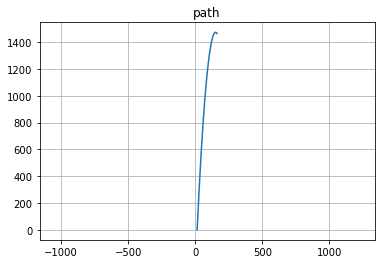

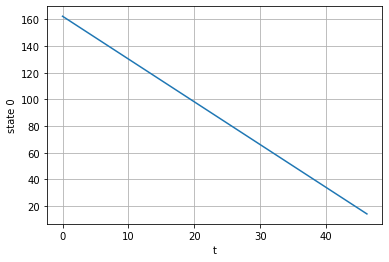

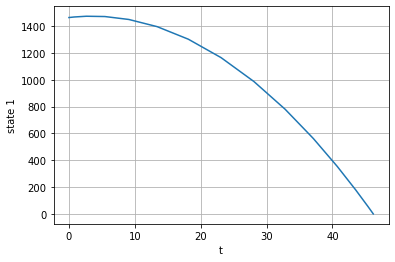

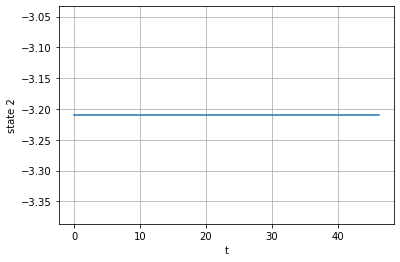

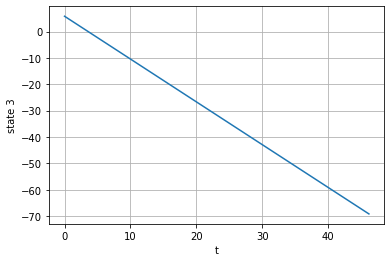

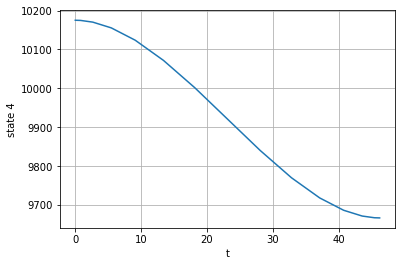

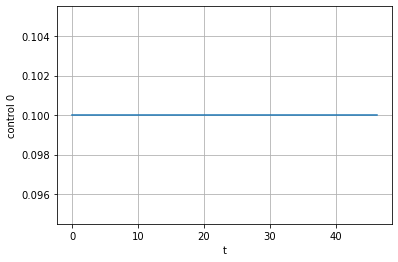

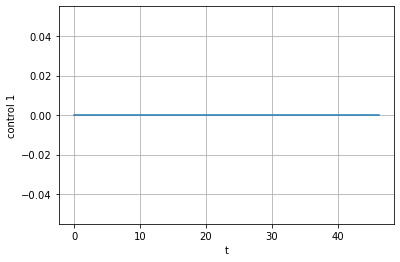

In [13]:
plt.plot(prob.states_all_section(0), prob.states_all_section(1))
ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.grid()
plt.title('path')
plt.show()

for i in range(5):
    plt.plot(prob.time_all_section, prob.states_all_section(i))
    plt.grid()
    plt.xlabel('t')
    plt.ylabel(f'state {i}')
    plt.show()
    
for i in range(2):
    plt.plot(prob.time_all_section, prob.controls_all_section(i))
    plt.grid()
    plt.xlabel('t')
    plt.ylabel(f'control {i}')
    plt.show()

In [14]:
def display_func():
    print(f'm/m0   : {prob.states_all_section(4)[-1]/r.m_0}')
    print(f't/tchar: {prob.time_final(-1)/r.t_char}')
    plt.plot(prob.states_all_section(0), prob.states_all_section(1))
    plt.grid()
    plt.show()

---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0
            Iterations: 26
            Function evaluations: 2927
            Gradient evaluations: 26
Iteration limit exceeded
m/m0   : 0.9395225698843734
t/tchar: 2.4918997764577298


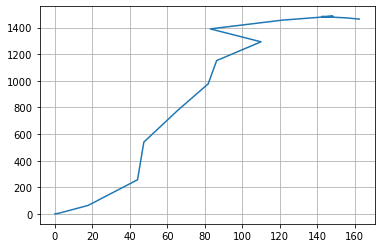


---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0
            Iterations: 26
            Function evaluations: 2958
            Gradient evaluations: 26
Iteration limit exceeded
m/m0   : 0.9395225698843402
t/tchar: 2.49189977649255


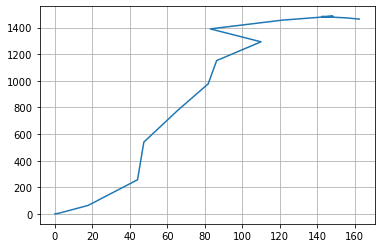


---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0
            Iterations: 26
            Function evaluations: 3010
            Gradient evaluations: 26
Iteration limit exceeded
m/m0   : 0.9395225698843069
t/tchar: 2.4918997765273434


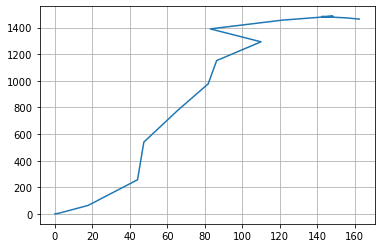


---- iteration : 4 ----
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 25
            Function evaluations: 2849
            Gradient evaluations: 25
Optimization terminated successfully.
m/m0   : 0.9395225698842737
t/tchar: 2.491899776239623


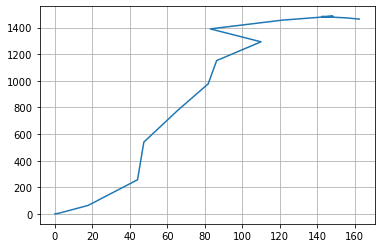

In [15]:
prob.solve(r, display_func, ftol=1e-10)

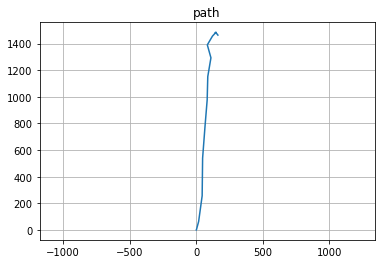

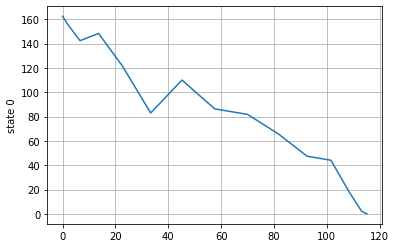

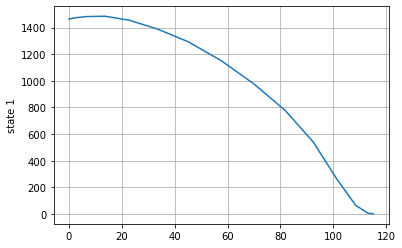

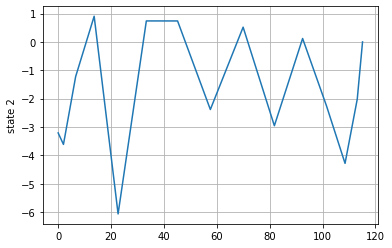

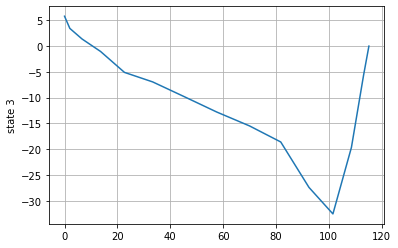

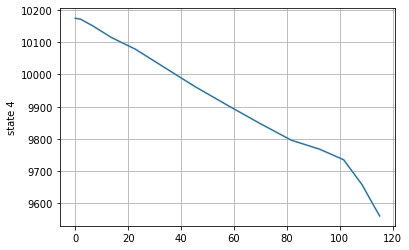

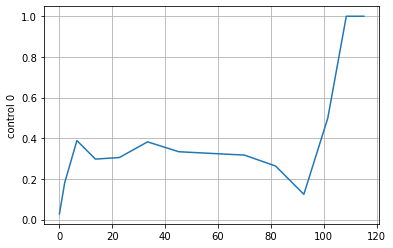

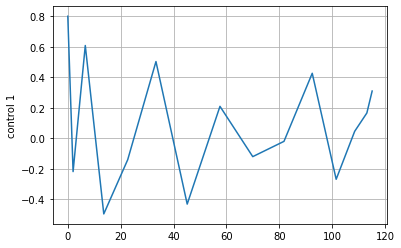

In [16]:
t_sol =  prob.time_update()

plt.plot(prob.states_all_section(0), prob.states_all_section(1))
ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.grid()
plt.title('path')
plt.show()



for i in range(5):
    plt.plot(t_sol, prob.states_all_section(i))
    plt.ylabel(f'state {i}')
    plt.grid()
    plt.show()
    
for i in range(2):
    plt.plot(t_sol, prob.controls_all_section(i))
    plt.ylabel(f'control {i}')
    plt.grid()
    plt.show()
    


In [17]:
prob

---- parameter ----
nodes = [15]
number of states    = [5]
number of controls  = [2]
number of sections  = 1
number of variables = 106
---- algorithm ----
max iteration = 20
---- function  ----
dynamics        = [<function og_dynamics at 0x121030950>]
cost            = <function og_cost at 0x1210307b8>
cost_derivative = None
equality        = <function og_equality at 0x121030b70>
inequality      = <function og_inequality at 0x121030730>
knot_states_smooth = [<function og_dynamics at 0x121030950>]

In [18]:
def global_mesh_refine(prob, new_nodes = None, maxIterator = None, **kwargs):
    
    time_init = prob.time_knots()
    
    if new_nodes is None:
        new_nodes = [2*n for n in prob.nodes]
    else:
        new_nodes = new_nodes
        
    num_of_states = prob.number_of_states
    
    num_of_controls = prob.number_of_controls
    
    if maxIterator is None:
        max_iter = prob.maxIterator
    else:
        max_iter = maxIterator
        
    new_prob = Problem(time_init, new_nodes, num_of_states, num_of_controls, max_iter, **kwargs)
    
    
    #assume the equations are the same as before
    new_prob.dynamics = prob.dynamics
    new_prob.knot_states_smooth = prob.knot_states_smooth
    new_prob.cost = prob.cost
    new_prob.cost_derivative = prob.cost_derivative
    new_prob.equality = prob.equality
    new_prob.inequality = prob.inequality
    
    
    #add in the initial guesses - linear interp on previous solution
    t_previous = prob.time_update() #update total 
    t_previous_section = prob.time
    
    t_new = new_prob.time_all_section
    t_new_section = new_prob.time
    
    for sec in range(len(new_nodes)):
        for i in range(num_of_states[sec]):
            new_prob.set_states(i, sec, np.interp(t_new_section[sec], t_previous_section[sec], prob.states(i, sec)))

        for i in range(num_of_controls[sec]):
            new_prob.set_controls(i, sec, np.interp(t_new_section[sec], t_previous_section[sec], prob.controls(i, sec)))
        
    return new_prob

In [19]:
new_prob = global_mesh_refine(prob)

In [20]:
new_prob

---- parameter ----
nodes = [30]
number of states    = [5]
number of controls  = [2]
number of sections  = 1
number of variables = 211
---- algorithm ----
max iteration = 20
---- function  ----
dynamics        = [<function og_dynamics at 0x121030950>]
cost            = <function og_cost at 0x1210307b8>
cost_derivative = None
equality        = <function og_equality at 0x121030b70>
inequality      = <function og_inequality at 0x121030730>
knot_states_smooth = [<function og_dynamics at 0x121030950>]

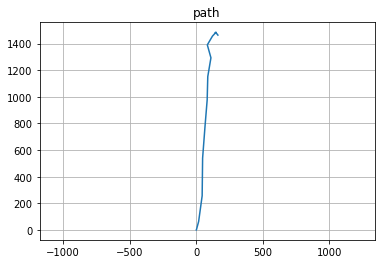

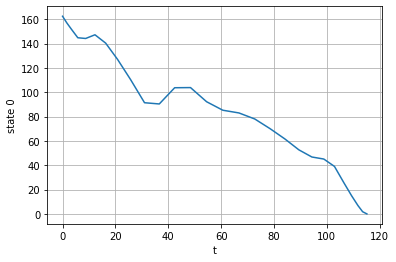

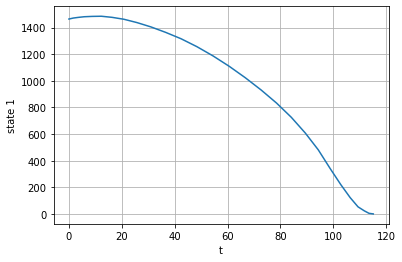

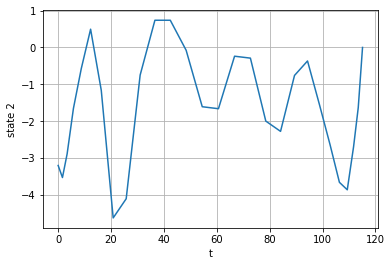

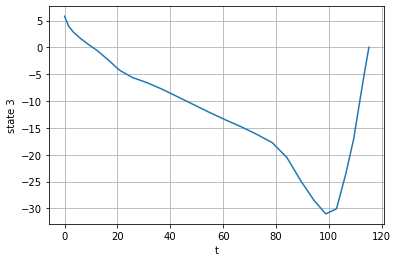

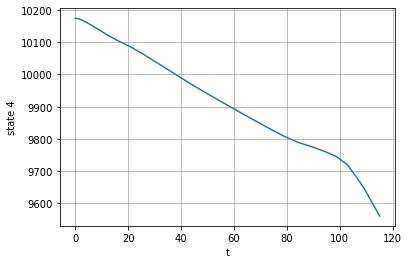

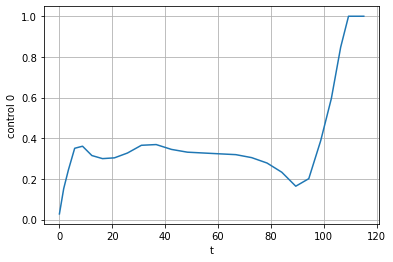

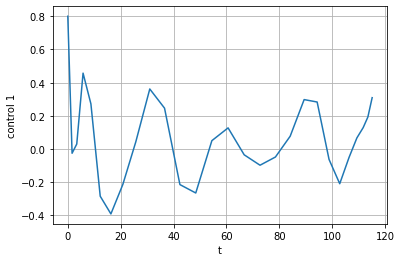

In [21]:
plt.plot(prob.states_all_section(0), prob.states_all_section(1))
ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.grid()
plt.title('path')
plt.show()



for i in range(5):
    plt.plot(new_prob.time_all_section, new_prob.states_all_section(i))
    plt.grid()
    plt.xlabel('t')
    plt.ylabel(f'state {i}')
    plt.show()
    
for i in range(2):
    plt.plot(new_prob.time_all_section, new_prob.controls_all_section(i))
    plt.grid()
    plt.xlabel('t')
    plt.ylabel(f'control {i}')
    plt.show()

In [22]:
def new_display_func():
    print(f'm/m0   : {new_prob.states_all_section(4)[-1]/r.m_0}')
    print(f't/tchar: {new_prob.time_final(-1)/r.t_char}')
    
    f, (ax1, ax2, ax3)= plt.subplots(1, 3)
    
    ax1.plot(new_prob.states_all_section(0), new_prob.states_all_section(1))
    ax1.set_aspect(aspect=1)
    ax2.plot(new_prob.time_update(), new_prob.controls_all_section(0))
    ax3.plot(new_prob.time_update(), (180/np.pi)*new_prob.controls_all_section(1))
    
    ax1.set_title('path')
    ax2.set_title('thrust fraction')
    ax3.set_title('thrust angle')
    
    ax3.set_ylim([-90, 90])
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.show()

In [23]:
new_prob.solve(r, ftol=1e-12)

---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0
            Iterations: 26
            Function evaluations: 5627
            Gradient evaluations: 26
Iteration limit exceeded

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0
            Iterations: 26
            Function evaluations: 5681
            Gradient evaluations: 26
Iteration limit exceeded

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0
            Iterations: 26
            Function evaluations: 5667
            Gradient evaluations: 26
Iteration limit exceeded

---- iteration : 4 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.0
            Iterations: 26
            Function evaluations: 5658
            Gradient evaluations: 26
Iteration limit exceeded

---- iteration : 5 ----
Iteration limit exceeded    (Exit mo

In [24]:
new_prob

---- parameter ----
nodes = [30]
number of states    = [5]
number of controls  = [2]
number of sections  = 1
number of variables = 211
---- algorithm ----
max iteration = 20
---- function  ----
dynamics        = [<function og_dynamics at 0x121030950>]
cost            = <function og_cost at 0x1210307b8>
cost_derivative = None
equality        = <function og_equality at 0x121030b70>
inequality      = <function og_inequality at 0x121030730>
knot_states_smooth = [<function og_dynamics at 0x121030950>]

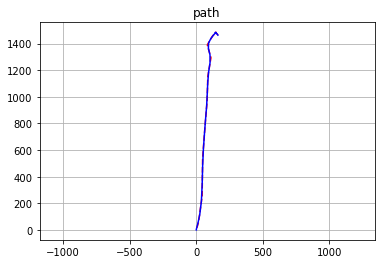

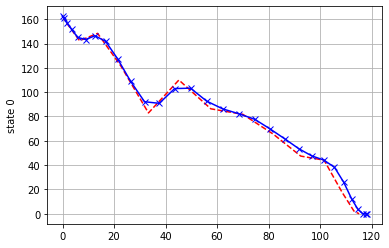

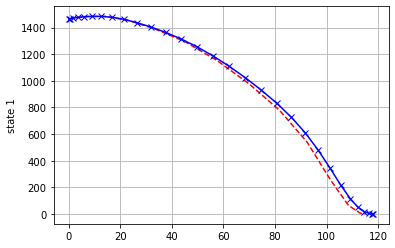

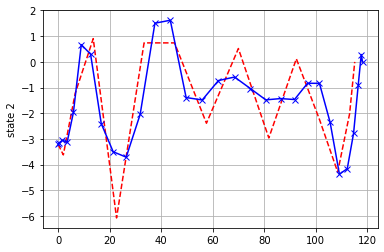

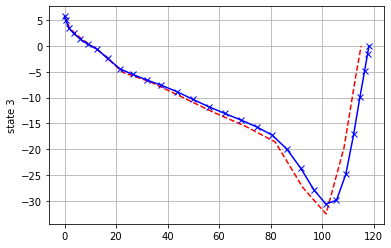

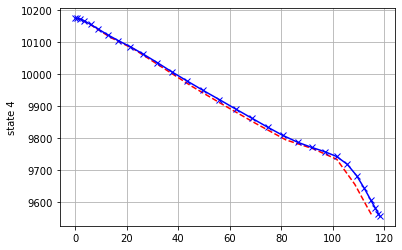

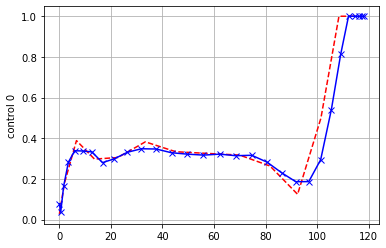

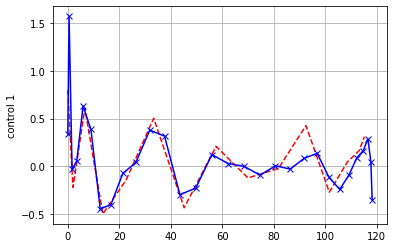

In [25]:
new_t_sol = new_prob.time_update()

plt.plot(prob.states_all_section(0), prob.states_all_section(1), 'r--')
plt.plot(new_prob.states_all_section(0), new_prob.states_all_section(1), 'b')
ax = plt.gca()
ax.set_aspect('equal', 'datalim')
plt.grid()
plt.title('path')
plt.show()



for i in range(5):
    plt.plot(t_sol, prob.states_all_section(i), 'r--')
    plt.plot(new_t_sol, new_prob.states_all_section(i),'bx-')
    plt.ylabel(f'state {i}')
    plt.grid()
    plt.show()
    
for i in range(2):
    plt.plot(t_sol, prob.controls_all_section(i), 'r--')
    plt.plot(new_t_sol, new_prob.controls_all_section(i), 'bx-')
    plt.ylabel(f'control {i}')
    plt.grid()
    plt.show()
    

